In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(54)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = mnist.load_data()


    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


In [5]:
#criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
criterias = [(0, 50, 0), (50, 100, 75), (100, 125, 124), (125, 150, 149), (150, 175, 174), (175, 200, 199), (200, 225, 224), (225, 256, 255)]
#criterias = []
kernel_size = 3
#kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(criterias, kernel_size, scaler, classes, features, dim = 10000)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


Using GPU!
Training...
Validating...
acc = 1.000000
acc_test = 0.968300
t = 111.319579


In [6]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [7]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 50736.24it/s]


In [8]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [9]:
attacker = GenAttack(model, classes, 28 * 28, model.scaler, 0.3, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [10]:
pops = []
results = []

In [11]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [02:59<4:55:38, 179.18s/it]

All 5000 generations failed.


  2%|▏         | 2/100 [05:03<3:59:56, 146.90s/it]

All 5000 generations failed.


  3%|▎         | 3/100 [07:04<3:38:04, 134.89s/it]

All 5000 generations failed.


  4%|▍         | 4/100 [09:05<3:27:24, 129.63s/it]

All 5000 generations failed.


  5%|▌         | 5/100 [11:05<3:19:47, 126.19s/it]

All 5000 generations failed.


  6%|▌         | 6/100 [13:02<3:12:46, 123.05s/it]

All 5000 generations failed.


  7%|▋         | 7/100 [15:02<3:09:09, 122.04s/it]

All 5000 generations failed.


  8%|▊         | 8/100 [17:04<3:06:55, 121.91s/it]

All 5000 generations failed.


  9%|▉         | 9/100 [19:05<3:04:21, 121.56s/it]

All 5000 generations failed.


 10%|█         | 10/100 [21:05<3:01:49, 121.22s/it]

All 5000 generations failed.


 11%|█         | 11/100 [23:05<2:59:23, 120.94s/it]

All 5000 generations failed.


 12%|█▏        | 12/100 [25:06<2:57:28, 121.00s/it]

All 5000 generations failed.


 13%|█▎        | 13/100 [27:10<2:56:22, 121.64s/it]

All 5000 generations failed.


 14%|█▍        | 14/100 [29:10<2:53:37, 121.14s/it]

All 5000 generations failed.


 15%|█▌        | 15/100 [31:10<2:51:23, 120.98s/it]

All 5000 generations failed.


 16%|█▌        | 16/100 [33:09<2:48:17, 120.21s/it]

All 5000 generations failed.


 17%|█▋        | 17/100 [35:10<2:46:37, 120.45s/it]

All 5000 generations failed.


 18%|█▊        | 18/100 [37:06<2:43:03, 119.31s/it]

All 5000 generations failed.


 19%|█▉        | 19/100 [39:06<2:41:20, 119.51s/it]

All 5000 generations failed.


 20%|██        | 20/100 [41:06<2:39:24, 119.56s/it]

All 5000 generations failed.


 21%|██        | 21/100 [43:06<2:37:41, 119.76s/it]

All 5000 generations failed.


 22%|██▏       | 22/100 [45:07<2:36:17, 120.22s/it]

All 5000 generations failed.


 23%|██▎       | 23/100 [47:10<2:35:03, 120.82s/it]

All 5000 generations failed.


 24%|██▍       | 24/100 [49:08<2:32:09, 120.12s/it]

All 5000 generations failed.


 25%|██▌       | 25/100 [51:10<2:30:55, 120.74s/it]

All 5000 generations failed.


 26%|██▌       | 26/100 [53:11<2:28:55, 120.75s/it]

All 5000 generations failed.


 27%|██▋       | 27/100 [55:11<2:26:30, 120.42s/it]

All 5000 generations failed.


 28%|██▊       | 28/100 [57:08<2:23:20, 119.45s/it]

All 5000 generations failed.


 29%|██▉       | 29/100 [59:10<2:22:14, 120.20s/it]

All 5000 generations failed.


 30%|███       | 30/100 [1:01:10<2:20:06, 120.09s/it]

All 5000 generations failed.


 31%|███       | 31/100 [1:03:18<2:21:00, 122.62s/it]

All 5000 generations failed.


 32%|███▏      | 32/100 [1:05:19<2:18:19, 122.04s/it]

All 5000 generations failed.


 33%|███▎      | 33/100 [1:07:20<2:15:48, 121.62s/it]

All 5000 generations failed.


 34%|███▍      | 34/100 [1:09:20<2:13:26, 121.31s/it]

All 5000 generations failed.


 35%|███▌      | 35/100 [1:11:20<2:10:51, 120.79s/it]

All 5000 generations failed.


 36%|███▌      | 36/100 [1:13:20<2:08:34, 120.53s/it]

All 5000 generations failed.


 37%|███▋      | 37/100 [1:15:21<2:06:55, 120.89s/it]

All 5000 generations failed.


 38%|███▊      | 38/100 [1:17:21<2:04:30, 120.49s/it]

All 5000 generations failed.


 39%|███▉      | 39/100 [1:19:21<2:02:13, 120.22s/it]

All 5000 generations failed.


 40%|████      | 40/100 [1:21:20<2:00:02, 120.04s/it]

All 5000 generations failed.


 41%|████      | 41/100 [1:23:20<1:58:04, 120.07s/it]

All 5000 generations failed.


 42%|████▏     | 42/100 [1:25:20<1:56:00, 120.01s/it]

All 5000 generations failed.


 43%|████▎     | 43/100 [1:27:23<1:54:40, 120.72s/it]

All 5000 generations failed.


 44%|████▍     | 44/100 [1:29:24<1:52:51, 120.92s/it]

All 5000 generations failed.


 45%|████▌     | 45/100 [1:31:24<1:50:36, 120.67s/it]

All 5000 generations failed.


 46%|████▌     | 46/100 [1:33:25<1:48:40, 120.74s/it]

All 5000 generations failed.


 47%|████▋     | 47/100 [1:35:26<1:46:44, 120.84s/it]

All 5000 generations failed.


 48%|████▊     | 48/100 [1:37:27<1:44:42, 120.81s/it]

All 5000 generations failed.


 49%|████▉     | 49/100 [1:39:26<1:42:15, 120.30s/it]

All 5000 generations failed.


 50%|█████     | 50/100 [1:41:26<1:40:12, 120.25s/it]

All 5000 generations failed.


 51%|█████     | 51/100 [1:43:27<1:38:18, 120.38s/it]

All 5000 generations failed.


 52%|█████▏    | 52/100 [1:45:28<1:36:32, 120.68s/it]

All 5000 generations failed.


 53%|█████▎    | 53/100 [1:47:32<1:35:15, 121.60s/it]

All 5000 generations failed.


 54%|█████▍    | 54/100 [1:49:33<1:33:02, 121.35s/it]

All 5000 generations failed.


 55%|█████▌    | 55/100 [1:51:37<1:31:45, 122.35s/it]

All 5000 generations failed.


 56%|█████▌    | 56/100 [1:53:38<1:29:16, 121.74s/it]

All 5000 generations failed.


 57%|█████▋    | 57/100 [1:55:38<1:26:53, 121.25s/it]

All 5000 generations failed.


 58%|█████▊    | 58/100 [1:57:38<1:24:35, 120.84s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [1:59:40<1:22:49, 121.21s/it]

All 5000 generations failed.


 60%|██████    | 60/100 [2:01:40<1:20:42, 121.05s/it]

All 5000 generations failed.


 61%|██████    | 61/100 [2:03:41<1:18:33, 120.85s/it]

All 5000 generations failed.


 62%|██████▏   | 62/100 [2:05:40<1:16:16, 120.44s/it]

All 5000 generations failed.


 63%|██████▎   | 63/100 [2:07:41<1:14:26, 120.71s/it]

All 5000 generations failed.


 64%|██████▍   | 64/100 [2:09:49<1:13:35, 122.66s/it]

All 5000 generations failed.


 65%|██████▌   | 65/100 [2:11:48<1:11:00, 121.73s/it]

All 5000 generations failed.


 66%|██████▌   | 66/100 [2:11:52<48:59, 86.44s/it]   

Attack Success at generation 172


 67%|██████▋   | 67/100 [2:13:55<53:26, 97.16s/it]

All 5000 generations failed.


 68%|██████▊   | 68/100 [2:15:56<55:44, 104.51s/it]

All 5000 generations failed.


 69%|██████▉   | 69/100 [2:17:59<56:47, 109.91s/it]

All 5000 generations failed.


 70%|███████   | 70/100 [2:19:59<56:28, 112.95s/it]

All 5000 generations failed.


 71%|███████   | 71/100 [2:21:59<55:37, 115.09s/it]

All 5000 generations failed.


 72%|███████▏  | 72/100 [2:24:00<54:30, 116.80s/it]

All 5000 generations failed.


 73%|███████▎  | 73/100 [2:26:02<53:17, 118.43s/it]

All 5000 generations failed.


 74%|███████▍  | 74/100 [2:28:02<51:28, 118.80s/it]

All 5000 generations failed.


 75%|███████▌  | 75/100 [2:30:03<49:48, 119.53s/it]

All 5000 generations failed.


 76%|███████▌  | 76/100 [2:32:04<48:02, 120.11s/it]

All 5000 generations failed.


 77%|███████▋  | 77/100 [2:34:04<45:57, 119.89s/it]

All 5000 generations failed.


 78%|███████▊  | 78/100 [2:36:04<43:59, 119.98s/it]

All 5000 generations failed.


 79%|███████▉  | 79/100 [2:38:05<42:07, 120.34s/it]

All 5000 generations failed.


 80%|████████  | 80/100 [2:40:05<40:04, 120.23s/it]

All 5000 generations failed.


 81%|████████  | 81/100 [2:42:05<38:02, 120.13s/it]

All 5000 generations failed.


 82%|████████▏ | 82/100 [2:44:04<35:57, 119.88s/it]

All 5000 generations failed.


 83%|████████▎ | 83/100 [2:46:05<34:01, 120.11s/it]

All 5000 generations failed.


 84%|████████▍ | 84/100 [2:48:07<32:10, 120.69s/it]

All 5000 generations failed.


 85%|████████▌ | 85/100 [2:49:42<28:16, 113.12s/it]

All 5000 generations failed.


 86%|████████▌ | 86/100 [2:51:45<27:04, 116.07s/it]

All 5000 generations failed.


 87%|████████▋ | 87/100 [2:53:50<25:41, 118.59s/it]

All 5000 generations failed.


 88%|████████▊ | 88/100 [2:55:49<23:47, 118.93s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [2:57:49<21:50, 119.14s/it]

All 5000 generations failed.


 90%|█████████ | 90/100 [2:59:50<19:55, 119.55s/it]

All 5000 generations failed.


 91%|█████████ | 91/100 [3:01:51<18:00, 120.09s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [3:03:51<16:00, 120.04s/it]

All 5000 generations failed.


 93%|█████████▎| 93/100 [3:05:51<13:59, 119.95s/it]

All 5000 generations failed.


 94%|█████████▍| 94/100 [3:07:53<12:03, 120.60s/it]

All 5000 generations failed.


 95%|█████████▌| 95/100 [3:09:53<10:02, 120.56s/it]

All 5000 generations failed.


 96%|█████████▌| 96/100 [3:11:19<07:20, 110.14s/it]

All 5000 generations failed.


In [ ]:
pops = np.array(pops)

In [ ]:
sample_preds = preds[indices]

In [ ]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [ ]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

93


In [ ]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [ ]:
torch.save(cache, 'robust_onlinehd_mnist.pt')

In [ ]:
model(torch.tensor(pops[13]))

tensor([8, 8, 8, 8, 8, 6, 8, 8], device='cuda:0')

In [ ]:
labels = {
    0 : '0',
    1 : '1',
    2 : '2',
    3 : '3',
    4 : '4',
    5 : '5',
    6 : '6',
    7 : '7',
    8 : '8',
    9 : '9'
}

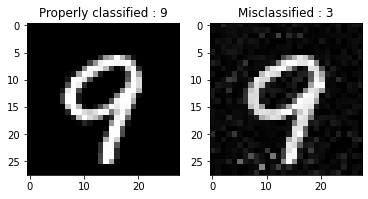

In [ ]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])